# Beginning with the original deep Q learning notebook for the polecart example

- Consider using this video recorder in the elementary Q-learning notebook. Likely this one is better for avoiding multiple episodes in one video (video_recorder.reset()).

# Swap of gym completed: following_enemy replaces polecart
- The changes required accomodating the Dict objects in the gym with the nparray objects in the Q-Learning
- Easiest was to return Dicts in gym as nparray (Dicts are only used locally within gym)
- Alternative was to reprogram Q-Learning with Dicts but it is unclear to me if the torch/cuda would work with that
- Or programming wrappers for dict-to-array and array-to-dict but would calling this within Q-Learning slow the learning too much?
### Results
- Enemy makes a beeline to Agent and catches him each time
- Which agent is learning?
- Why can't Agent dodge Enemy like in Elementary Q-Learning?

# Next steps

- Modify the gym and Q-learning for two learning agents and make the following enemy race to the target, maybe similar starting positions
- Modify the "following enemy" game to make Tron cycle race

# **Deep Reinforcement Learning**

Objectives: Train Deep Reinforcement Learning methods on the [CArt Pole](https://www.gymlibrary.dev/environments/classic_control/cart_pole/) and [Bipedal Walker](https://www.gymlibrary.dev/environments/box2d/bipedal_walker/) OpenAI Gym environments

1.   Improve the DQN agent already implemented by modifying the DQN, or by searching for better parameters
2.   Apply Policy-based/Actor Critic agent to the Bipedal Walker environment







To use GPU, set `Edit / Notebook settings / Hardware accelerator` to **GPU**.

Install needed Python packages

In [309]:
#!pip install pygame gym[box2D] numpy

Import basic Python packages

In [310]:
import gym
from gym import spaces
import pygame
import numpy as np
import random

Mount Google Drive for saving results (not needed if running the notebook locally)

In [311]:
# Mount Google Drive
#from google.colab import drive # import drive from google colab

#ROOT = "/content/drive"         # default location for the drive

#drive.mount(ROOT)              # we mount the google drive at /content/drive

## Video Utilities

In [312]:
from pathlib import Path
import base64
from IPython import display as ipythondisplay
from gym.wrappers import RecordVideo

In [313]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [314]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [315]:
def record_video_randpol(env, video_length=0, step_trigger=None, episode_trigger=None,  prefix='', video_folder='videos/'):

  video_env = RecordVideo(env, 
                         video_folder=video_folder,
                         episode_trigger=episode_trigger,
                         step_trigger=step_trigger,
                         video_length=video_length,
                         name_prefix=prefix,
                         new_step_api=True
                         )
  
  observation = video_env.reset()

  step = 0
  ep = 0

  while True:

    if _iterate_condition(step, ep, video_length=video_length, step_trigger=step_trigger, episode_trigger=episode_trigger):

      observation, reward, terminated, _, info = video_env.step(env.action_space.sample())
      step += 1

      if terminated:
        observation = video_env.reset()
        ep += 1
        step = 0
    
    else:
      break
      
  video_env.close()

# Utility function for checking stopping condition
def _iterate_condition(step, ep, video_length=0, step_trigger=None, episode_trigger=None):

  if video_length is not 0:
    go = True if step < video_length else False
    return go

  if step_trigger is not None:
    go = step_trigger(step)
    return go

  if episode_trigger is not None:
    go = episode_trigger(ep)
    return go

In [316]:
# Set up fake display; otherwise rendering will fail on Google Colab
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [317]:
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

# **1) Improve DQN Agent on `CartPole-v0`**

## Inspect `CartPole-v0` environment

Initialize environment with discrete action space (necessary for DQN)

In [318]:
#env = gym.make(
#    "CartPole-v1",
#    new_step_api=True
#)

In [319]:
class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
        # Replace dict with box array for deep q learning
        #self.observation_space = spaces.Dict(
        #    {
        #        "agent": spaces.Box(0, size - 1, shape=(2,), dtype=int),
        #        "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
        #        "enemy": spaces.Box(0, size - 1, shape=(2,), dtype=int),
        #    }
        #)
        low=np.array([0,0,0,0,0,0],dtype=int)#ax,ay,ex,ey,tx,ty
        high=np.array([size-1,size-1,size-1,size-1,size-1,size-1],dtype=int)#ax,ay,ex,ey,tx,ty
        self.observation_space = spaces.Box(low,high, dtype=int)

        # We have 4 actions, corresponding to "right", "up", "left", "down"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    # Private method to get observations
    def _get_obs(self):
        #return {"agent": self._agent_location, "target": self._target_location, "enemy": self._enemy_location}
        return np.array([self._agent_location[0],self._agent_location[1],self._enemy_location[0],self._enemy_location[1],self._target_location[0],self._target_location[1]],dtype=int)

    # Private method to get info
    def _get_info(self):
        return {"distance": np.linalg.norm(self._agent_location - self._target_location, ord=1)}

    # Private method to get reward
    def _get_reward(self):
        return np.array([self._agent_reward, self._enemy_reward], dtype=float)
    
    # Reset method for the environment
    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)
#        # Choose target, agent, enemy starting locations
        cells=np.array(range(0,self.size**2))
        a=cells.reshape(self.size,self.size)
        for i in range(4):
            n=random.choice(cells)
            coords=np.unravel_index(n,a.shape)

            if i == 0:
                self._agent_location = np.asarray(coords)
            elif i == 1:
                self._enemy_location = np.asarray(coords)
            else:
                self._target_location = np.asarray(coords)
            np.delete(cells,n)

        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    # Step method for the environment
    def step(self, action):

# enemy action = 0,1,2,3
# choose which one based on shortest path to agent's location in last step
# if minimum distance to agent is only one square, move randomly
        
        enemy_action=-1
        mindist=1000.
        grid_distance = self._agent_location - self._enemy_location
 #       print(f" grid_distance {grid_distance[0]} {grid_distance[1]}")
 # Use range (0,3) here if it doesn't change the result ?!
        for i in range(4):
           if np.linalg.norm(grid_distance-self._action_to_direction[i]) <= mindist:
                mindist=np.linalg.norm(grid_distance-self._action_to_direction[i])
                enemy_action=i
        #if mindist < 1:
        #    enemy_action = self.action_space.sample()
            #print(f"before clip mindist {mindist} {self._enemy_location} {self._agent_location}")
        # Map the action (element of {0,1,2,3}) to the direction we walk 
        direction_enemy = self._action_to_direction[enemy_action]
        direction_agent = self._action_to_direction[action]

        # We use `np.clip` to make sure we don't leave the grid
        self._agent_location = np.clip(self._agent_location + direction_agent, 0, self.size - 1)
        self._enemy_location = np.clip(self._enemy_location + direction_enemy, 0, self.size - 1)
        
        #    print(f"after clip mindist {mindist} {self._enemy_location} {self._agent_location}")

        # An episode is done if the agent has reached the target, hit the enemy or if enemy reaches target
        self._agent_reward=0
        self._enemy_reward=0
        terminated = np.array_equal(self._agent_location, self._target_location) or np.array_equal(self._agent_location, self._enemy_location) or np.array_equal(self._target_location, self._enemy_location)
        # Agent beats enemy to target
        won = np.array_equal(self._target_location, self._agent_location)
        # Enemy catches agent
        caught = np.array_equal(self._agent_location, self._enemy_location)
        # Enemy beats agent to target
        lost = np.array_equal(self._enemy_location, self._target_location)
    
     #   reward = 1 if terminated else 0  # Binary sparse rewards
        if terminated == False:  # case when game ends in stalemate
            self._agent_reward=0.
            self._enemy_reward=0.
        if terminated and won:
            self._agent_reward=1.
            self._enemy_reward=0.
        elif terminated and caught:
            self._agent_reward=-0.5
            self._enemy_reward=1.
        elif terminated and lost:
            self._agent_reward=-1.0
            self._enemy_reward=0.

        observation = self._get_obs()
        info = self._get_info()
        reward=self._get_reward()
       # info = print(f"Terminated. Reward = {reward}")

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    # Render method for visualization
    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Draw enemy
        pygame.draw.circle(canvas,(0,0,0),(self._enemy_location + 0.5) * pix_square_size, pix_square_size/3,)

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )


In [320]:
grid_size=5
env=GridWorldEnv(render_mode="rgb_array",size=grid_size)

Record and show video

In [321]:
import sys
import os

is_colab = 'google.colab' in sys.modules
root_dir ='drive/MyDrive/CASAdvancedML' if is_colab else '.'

In [322]:
video_folder = os.path.join(root_dir, 'Videos')
os.makedirs(video_folder, exist_ok =True)

prefix = 'deep_q_follow_enemy'

record_video_randpol(env,
                     video_length=0,
                     episode_trigger=lambda ep: ep == 0,
                     step_trigger=None,
                     prefix=prefix,
                     video_folder=video_folder)

show_videos(video_folder, prefix=prefix)

c:\Users\jkhac\anaconda3\envs\p3712torch\lib\site-packages\gym\wrappers\record_video.py:79: UserWarning: WARN: Overwriting existing videos at c:\Users\jkhac\Documents\AML\Module 3 Deep Learning Research\CAS-AML-M3-main\ReinforcementLearning\Videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder "


In [323]:
print('The action space of the environment is of dimension: {}'.format(env.action_space.n))
print('The observation space of the environment is of dimension {}'.format(env.observation_space.sample().shape[0]))

The action space of the environment is of dimension: 4
The observation space of the environment is of dimension 6


## Deep Q-Learning Agent

**Replay Memory**: The agent needs a memory buffer to sample experience from

In [324]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):

        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def add(
        self,
        obs: np.ndarray,
        act: np.ndarray, 
        rew: float, 
        next_obs: np.ndarray, 
        done: bool,
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self):
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return (torch.from_numpy(self.obs_buf[idxs]).to(self.device),
                torch.from_numpy(self.acts_buf[idxs]).long().to(self.device),
                torch.from_numpy(self.rews_buf[idxs]).to(self.device),
                torch.from_numpy(self.next_obs_buf[idxs]).to(self.device),
                torch.from_numpy(self.done_buf[idxs]).to(self.device))

    def __len__(self):
        return self.size

**DQN**: The Q network that returns Q-values for state-action pairs

In [325]:
import torch
from torch import nn
import torch.nn.functional as F


class DQN(nn.Module):

    def __init__(self, action_size, input_dim=1):
        super(DQN, self).__init__()

        self.action_size = action_size 

        # Network
       # print(f"dqn init {action_size}")
        self.f1 =  nn.Linear(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.f2 = nn.Linear(32, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.head = nn.Linear(32, self.action_size)

        # Device
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):

        x = x.to(self.device)

        x = F.relu(self.bn1(self.f1(x)))
        x = F.relu(self.bn2(self.f2(x)))
        
        return self.head(x)
        

**Agent**: The Python class featuring the main learning steps for the DQN agent

In [326]:
#import torch
#torch.cuda.is_available()

In [327]:
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [328]:
#torch.cuda.get_device_name(torch.device('cuda:0'))

In [329]:
from math import tau
from torch import optim
import random

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, dqn, memory, index, lr=1e-4, batch_size=64, update_every=5, gamma=0.99, tau=1e-3, epsilon=0.1, seed=0, render=False, optimal=False):
        """Initialize an Agent object.
        
        Params
        ======
            dqn (nn.Module): Module implementing the DQN
            memory (object): Replay buffer object
            seed (int): Random seed
        """

        # Device
        torch.cuda.set_device(0)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #os.environ['CUDA_VISIBLE_DEVICES'] = "0"
        

        # Q-Network
        self.qnetwork_local = dqn.to(self.device)
        self.qnetwork_target = dqn.to(self.device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)

        # Other params
        self.lr = lr
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma
        self.tau = tau
        self.epsilon = epsilon

        # index tells us which reward to use, i.e. which agent is replaying
        self.index = index

        self.render = render
        self.optimal = optimal

        # Replay memory
        self.memory = memory
        # Initialize time step (for updating every update_every steps)
        self.t_step = 0

    def episode(self, env, max_steps=1000):
        
        state = env.reset()[0]
        score = 0

        if self.render:
          env.render()

        for _ in range(max_steps):
            action = self.act(state, self.epsilon)
            a = env.step(action)[0]
            next_state, reward, done, _, info = env.step(action)

            if not(self.optimal):

###
# Apply index here to send the reward corresponding to the agent to the dqn
###
              self.step(state, action, reward[self.index], next_state, done)
              
            state = next_state
            score += reward
            if done:
                break
        return score[self.index]

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every update_every time steps
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) >  self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        """
        states, actions, rewards, next_states, dones = experiences
        
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards.unsqueeze(1) + (self.gamma * Q_targets_next * (1 - dones.unsqueeze(1)))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions.unsqueeze(1))

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)                     

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        # Next two lines take values from dict and express them as np.array for DQN
#        state=np.array(list(state[0].values()))
#        state = torch.from_numpy(state.flatten()).float().unsqueeze(0).to(self.device)
        #print(f"Agent_act state {state}")
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.qnetwork_local.eval()

        with torch.no_grad():
         #   print(state)
         #   print(env.action_space.n)
         #   print(env.observation_space.shape[0])
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.qnetwork_local.action_size))

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


**Main training function**: the function that trains the agent on the environment

In [330]:
from tqdm import tqdm

def DeepQLearning(env: gym.Env, agent: object, num_episodes: int, max_steps=1000, save_model=None):

  reward_per_ep = list()

  for i in tqdm(range(num_episodes)):
    reward = agent.episode(env, max_steps=max_steps)
    reward_per_ep.append(reward)
  
  if save_model is not None:
    torch.save(agent.qnetwork_local.state_dict(), save_model)

  return reward_per_ep

# Two Agents in list, two models to save. Reward nparray.

- How is "memory" object related to Agent and how to make sure it's the right one for each Agent?

In [331]:
def DeepQLearning2(env: gym.Env, agentlist: dict, num_episodes: int, max_steps=1000, save_model=None):

  reward_per_ep = np.zeros((len(agentlist["agent"]), num_episodes), dtype=float)

  for i in tqdm(range(num_episodes)):
    for j in range(len(agentlist["agent"])):
        reward = agentlist["agent"][j].episode(env, max_steps=max_steps)
        reward_per_ep[j,i]=reward
  
  if save_model is not None:
    for ii in range(len(save_model)):
      torch.save(agentlist["agent"][ii].qnetwork_local.state_dict(), save_model[ii])

  return reward_per_ep

## Training & Evaluation

Define parameters and initialize modules

? Can I define Agent as any of the agents in env?
? can I link the memory to this agent specifically?
? Or make "memory" and "agent" lists that contain ALL of the agents and relevant memory
NOthing in env defines "agent" does it? "enemy" and "target" are also agents?

In [332]:
# set parameters of the Agent and ReplayBuffer
lr = 1e-4#1e-4
batch_size = 64#64
update_every = 5 #5
gamma = 0.99#0.99  reward discounting
tau = 0.5#0.5
epsilon = 0.1#0.1

buffer_size=int(1e+3)
seed=0
dim_obs_space=env.observation_space.shape[0]

# instantiate Q-network
dqn1 = DQN(action_size=env.action_space.n,
          input_dim=env.observation_space.shape[0])

# instantiate memory buffer
memory1 = ReplayBuffer(obs_dim=env.observation_space.shape[0],
                      size=buffer_size,
                      batch_size=batch_size)
# instantiate agent
agent1 = Agent(dqn1,
              memory1,
              0,
              lr=lr,
              batch_size=batch_size,
              update_every=update_every, 
              gamma=gamma,
              tau=tau,
              epsilon=epsilon)

# instantiate Q-network
dqn2 = DQN(action_size=env.action_space.n,
          input_dim=env.observation_space.shape[0])

# instantiate memory buffer
memory2 = ReplayBuffer(obs_dim=env.observation_space.shape[0],
                      size=buffer_size,
                      batch_size=batch_size)
# instantiate agent
agent2 = Agent(dqn2,
              memory2,
              1,
              lr=lr,
              batch_size=batch_size,
              update_every=update_every, 
              gamma=gamma,
              tau=tau,
              epsilon=epsilon)

agentlist={}
agentlist["dqn"]=[dqn1,dqn2]
agentlist["memory"]=[memory1,memory2]
agentlist["agent"]=[agent1,agent2]

# number of episodes and file path to save the model
num_episodes = 5000
model_dir = os.path.join(root_dir, 'Models')
save_model = [os.path.join(model_dir, 'agent1_dqn_{}episodes.pth'.format(num_episodes)),os.path.join(model_dir, 'agent2_dqn_{}episodes.pth'.format(num_episodes))]
os.makedirs(model_dir, exist_ok =True)

In [333]:
#torch.cuda.memory_stats(torch.device('cuda:0'))

Run training loop

In [334]:
R = DeepQLearning2(env, agentlist, num_episodes, save_model=save_model)

100%|██████████| 5000/5000 [21:41<00:00,  3.84it/s]


Plot learning curve (i.e., average reward over fixed window)

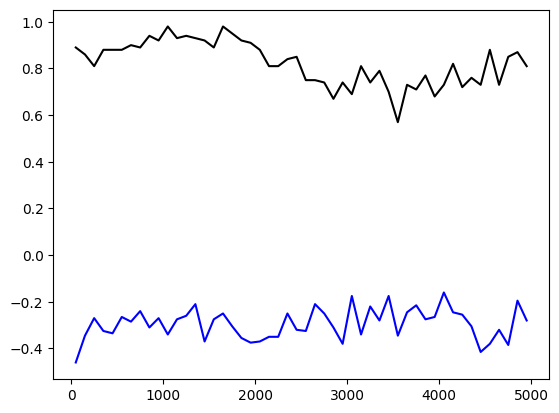

In [335]:
from matplotlib import pyplot as plt

def averagewindow(R, d=1):
    n = len(R)
    t = []
    y = []
    for i in range(0,int(n/d)):
        t.append(np.mean(range(i*d,(i+1)*d)));
        y.append(np.mean(R[i*d:min(n,(i+1)*d)]))
    return t,y

window = 100
t,y1 = averagewindow(R[0], d=window)
plt.plot(t, y1, color="b", label="Agent")
t,y2 = averagewindow(R[1], d=window)
plt.plot(t,y2,color="k", label="Enemy")


In [342]:
import os

# set parameters to evaluate agent
agent1.optimal = True
agent1.epsilon = 0.0
agent2.optimal = True
agent2.epsilon = 0.0
vid_episodes = 5
prefix = os.path.basename(save_model[0]).split('.')[0]

# use wrapper to record videos
env_vid = RecordVideo(env, 
                      video_folder=video_folder,
                      episode_trigger=lambda ep: (ep < vid_episodes),
                      step_trigger=None,
                      video_length=0,
                      name_prefix=prefix,
                      new_step_api=True
                      )

# use wrapper to record videos
R_test = DeepQLearning2(env_vid, agentlist, vid_episodes)


100%|██████████| 5/5 [00:07<00:00,  1.48s/it]


In [343]:
show_videos(video_folder, prefix=prefix)

## Improve the current agent

Pick (at least) one of the following tasks:

1.   Look for better hyper-parameters of the algorithm (e.g., learning rate, batch size, epsilon, etc.).
2.   Focus on the DQN architecture. For instance, add regularization techniques (e.g., dropout) in the current feed-forward network. Otherwise, you could embed temporal information into the Q network by using the [Frame Stack](https://www.gymlibrary.dev/api/wrappers/#available-wrappers) wrapper for feeding sequential data and [Recurrent](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)/[Attention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html) layers for processing them.



In [338]:
# TO COMPLETE

# **2) Implement Deep RL Algorithm on `BipedalWalker-v3`**

Further documentation for this environment is available [here](https://www.gymlibrary.dev/environments/box2d/bipedal_walker/).

Note: this environment does not provide discrete actions. Therefore, the vanilla DQN algorithm can't be applied without discretizing etc.
Implement a policy/actor-critic approach to deal with continous action spaces.

Hint: You can modify the previously defined `Agent` class to implement the [Deep Deterministic Policy Gradient](https://arxiv.org/pdf/1509.02971.pdf) (DDPG) algorithm (check in particular Algorithm 1 of the paper). Most of the Deep RL algorthms need replay buffers, so the `ReplayBuffer` class can be directly re-used.
Also, many implementations online (e.g., https://spinningup.openai.com/en/latest/_modules/spinup/algos/pytorch/ddpg/ddpg.html)

Instantiate `BipedalWalker-v3` environment

In [339]:
#env = gym.make(
#    "BipedalWalker-v3",
#    new_step_api=True
#)

Record and show video

In [340]:
#prefix = 'bipwalk_random'
#
#record_video_randpol(env,
#                     video_length=100,
#                     episode_trigger=None,
#                     step_trigger=None,
#                     prefix=prefix,
#                     video_folder=video_folder)
#
#show_videos(video_folder, prefix=prefix)

Update `Agent` class and write additional required classes

In [341]:
# TO COMPLETE